# Self-Driving Car Engineer Nanodegree

# Project: Advance lane Detection

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



### Note:  Most of the below functions are taken from the course assignments itself

## Import Packages

In [1]:
# ADVANCE LANE DETECTION 

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
%matplotlib inline

## Calibrate Camera
    
    

In [2]:
# Read test images for camera caliberation 
import os
os.listdir("camera_cal/")

['calibration8.jpg',
 'calibration2.jpg',
 'calibration13.jpg',
 'calibration20.jpg',
 'calibration6.jpg',
 'calibration16.jpg',
 'calibration17.jpg',
 'calibration1.jpg',
 'calibration9.jpg',
 'calibration15.jpg',
 'calibration12.jpg',
 'calibration7.jpg',
 'calibration14.jpg',
 'calibration4.jpg',
 'calibration3.jpg',
 'calibration5.jpg',
 'calibration11.jpg',
 'calibration10.jpg',
 'calibration18.jpg',
 'calibration19.jpg']

In [3]:
# caliberation dimentions for chess board
chess_x = 9 
chess_y = 6

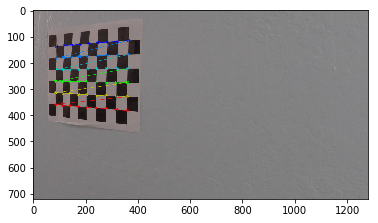

In [91]:
# prepare object points
    
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((chess_y*chess_x,3), np.float32)
objp[:,:2] = np.mgrid[0:chess_x, 0:chess_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chess_x,chess_y), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (chess_x,chess_y), corners, ret)
        write_name = 'output_images/corners_found_'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img) 
        plt.imshow(img)



### Above corner detectected and saved in the 'output_images' folder 

Above image is one of the examples 

In [5]:
# Undistort an image and create a function that can be used again
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

Text(0.5,1,'Undistorted Image')

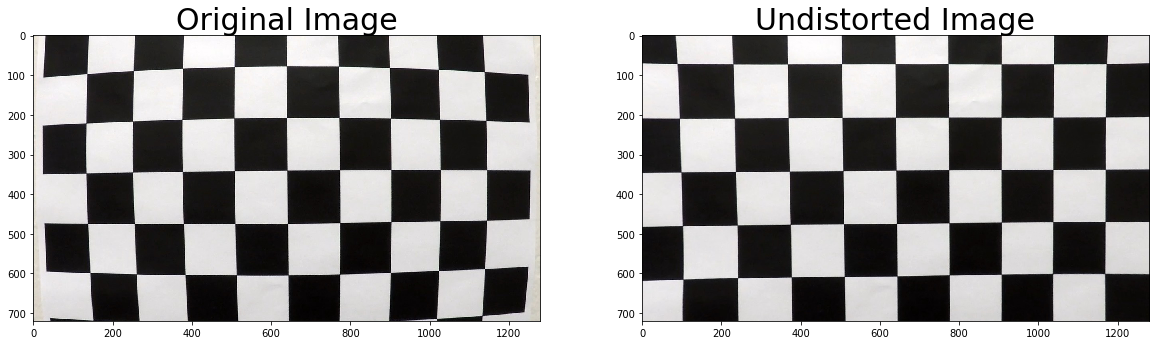

In [6]:
# Test undistortion on an calibration1.jpg
img1 = mpimg.imread('camera_cal/calibration1.jpg')
undist, mtx, dist = cal_undistort(img1, objpoints, imgpoints)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)


#### now warp  the image to look at the birds eye view and create a function so that it can be re-used

In [8]:
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped

####  Try warping chess board 

False

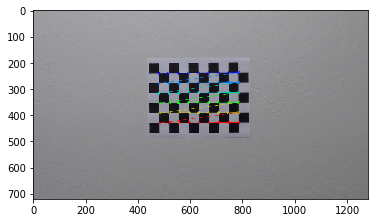

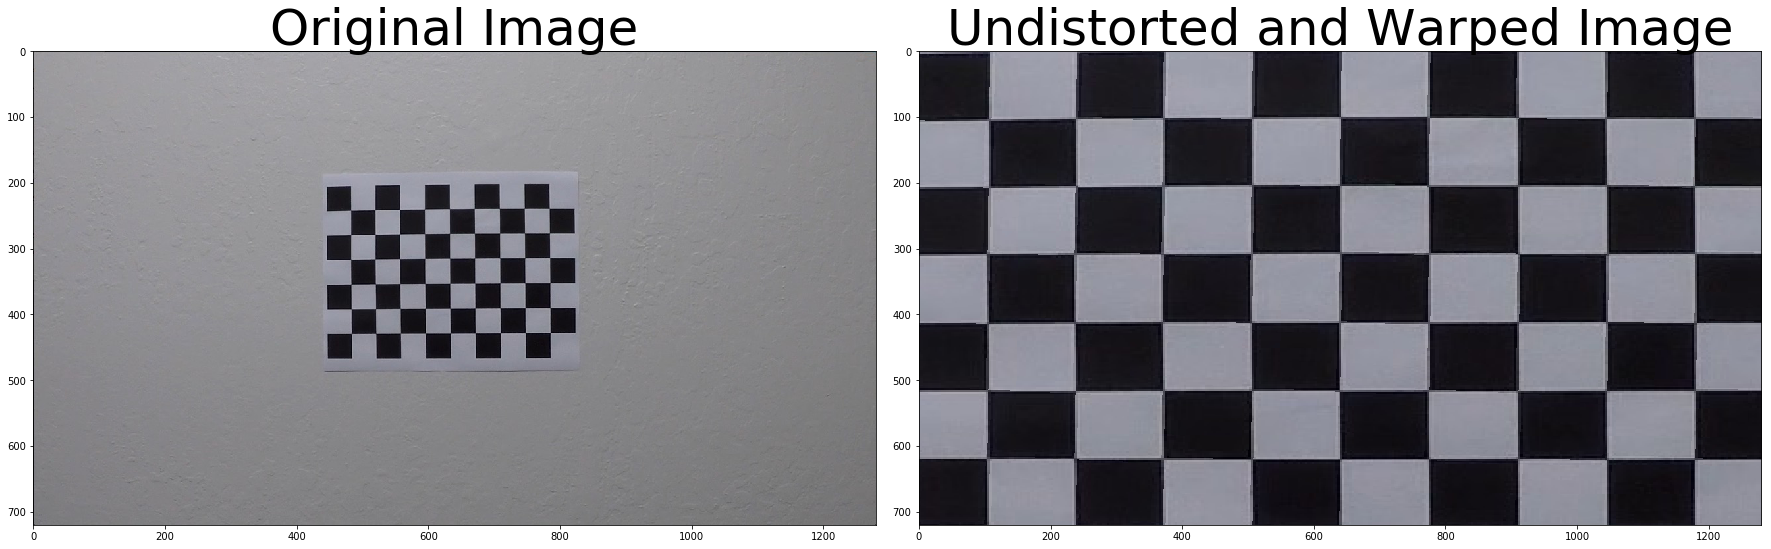

In [119]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert to grayscale
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # print (corners)
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(dst, (nx, ny), corners, ret)
        plt.imshow(dst)
        offset = 100
        img_size = (gray.shape[1], gray.shape[0])
        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], [img_size[0]-offset, img_size[1]-offset], [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        warped = warper(img, src, dst)
        return warped

img1 = mpimg.imread('camera_cal/calibration6.jpg')
# top_down, perspective_M = corners_unwarp(img1, chess_x, chess_y, mtx, dist)
top_down = corners_unwarp(img1, chess_x, chess_y, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
write_name = 'output_images/calibration_output_6.jpg'
cv2.imwrite(write_name, image_result)





## Use color transforms, gradients, etc., to create a thresholded binary image.

In [18]:
def calculate_grad(img, orient='x', sobel_kernel=3):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    return sobel


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    abs_sobel = np.absolute(calculate_grad(img, orient, sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx = calculate_grad(image, 'x', sobel_kernel)
    sobely = calculate_grad(image, 'y', sobel_kernel)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    abs_sobelx = np.absolute(calculate_grad(image, 'x', sobel_kernel))
    abs_sobely = np.absolute(calculate_grad(image, 'y', sobel_kernel))
    dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir)
    dir_binary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    #binary_output = np.copy(img) # Remove this line
    return dir_binary

def apply_all_threshold(image, ksize = 3):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 200))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 200))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 200))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

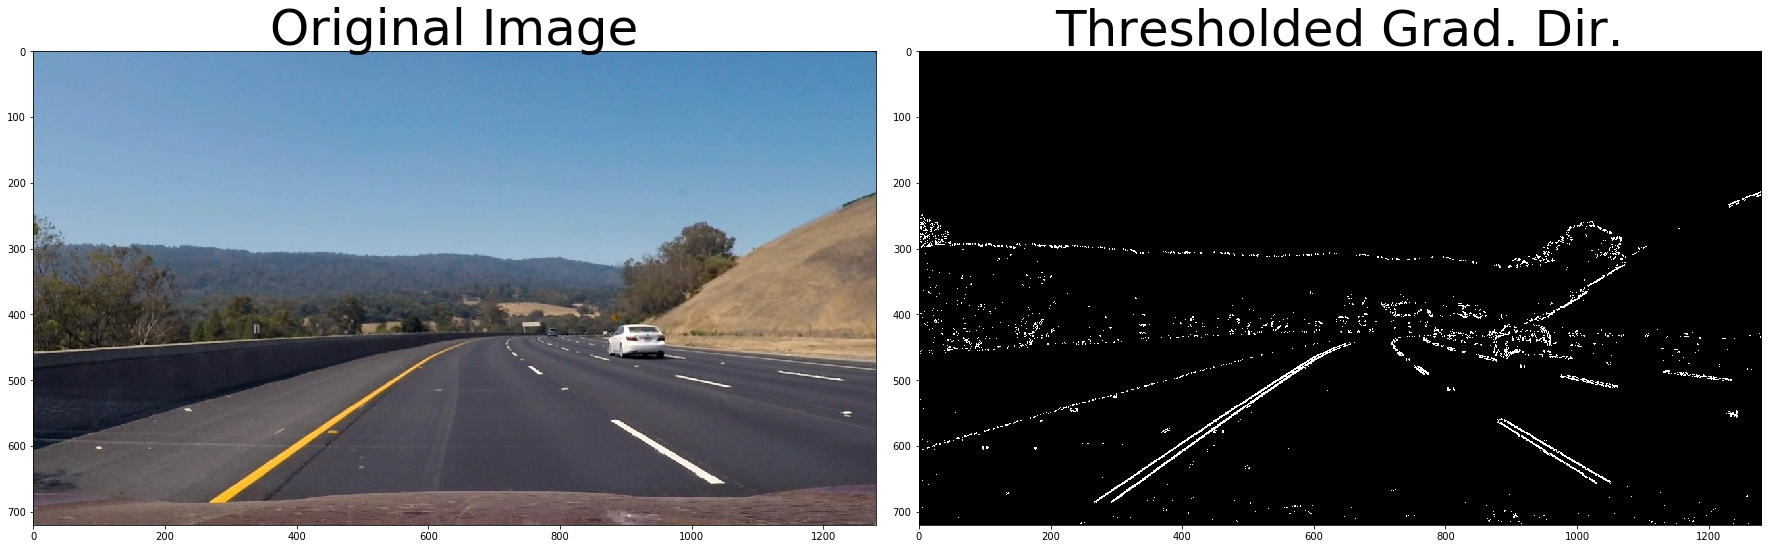

In [19]:
# Test threshold filters on image

image = mpimg.imread('test_images/test3.jpg')
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
combined = apply_all_threshold(image, ksize = 3)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Apply a distortion correction to raw images.


We will use the same coffiecients for the test images that we claculated in the above step. assuming that same camera is used

Text(0.5,1,'Undistorted Image')

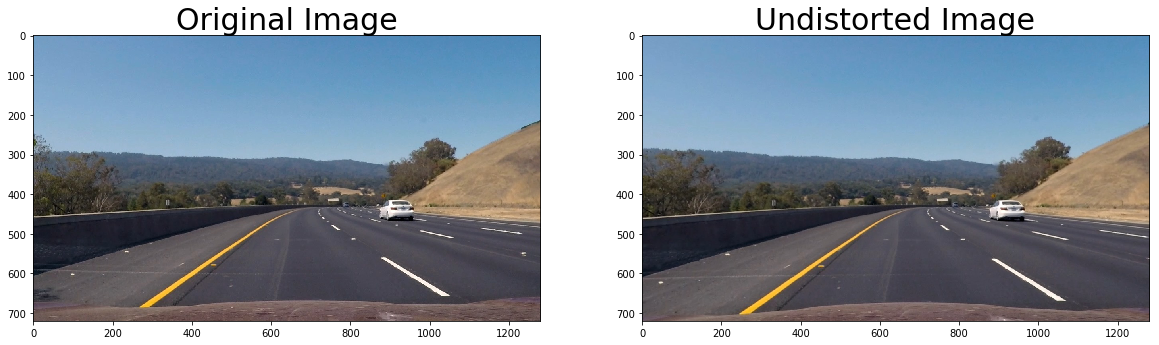

In [17]:
img1 = mpimg.imread('test_images/test3.jpg')

undist, mtx, dist = cal_undistort(img1, objpoints, imgpoints)
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

### Explain distortion in the above image: 

As we can see above two images the difference is change in the distortion 
Distortion is less at the center and more at the corners of the image  
by using parameters callculated before we will undistort the image 
Distortion can be easily seen at the bottom of the image  

## Warp image and apply threshold


Use any one image to find correct lane  we will take straight line image 

We will use region of interest to find the correct warping of the images 

In [68]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

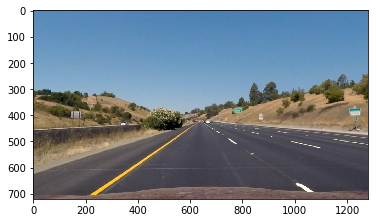

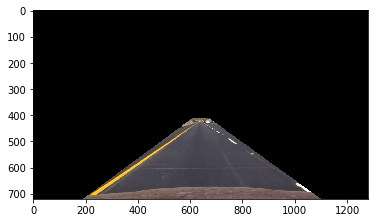

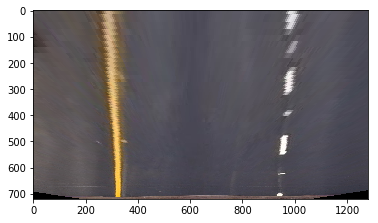

True

In [124]:
image = mpimg.imread('test_images/straight_lines1.jpg')

im_dst = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(im_dst)
plt.show()
imshape = im_dst.shape
vertices = np.array([[(190,720),(610, 410),(670, 410), (1100,720)]],dtype=np.int32)
img_roi = region_of_interest(im_dst, vertices)
plt.imshow(img_roi)
plt.show()

src = np.array([[(196,720),(600, 450),(680, 450), (1135,720)]],dtype=np.float32)
dst = np.array([[(320,720),(320, 0),(960, 0),(960,720)]], dtype=np.float32)
warped = warper(image, src, dst)

plt.imshow(warped)
plt.show()
write_name = 'output_images/warped_result.jpg'
cv2.imwrite(write_name, warped)

### use pipeline on wraped to app

True

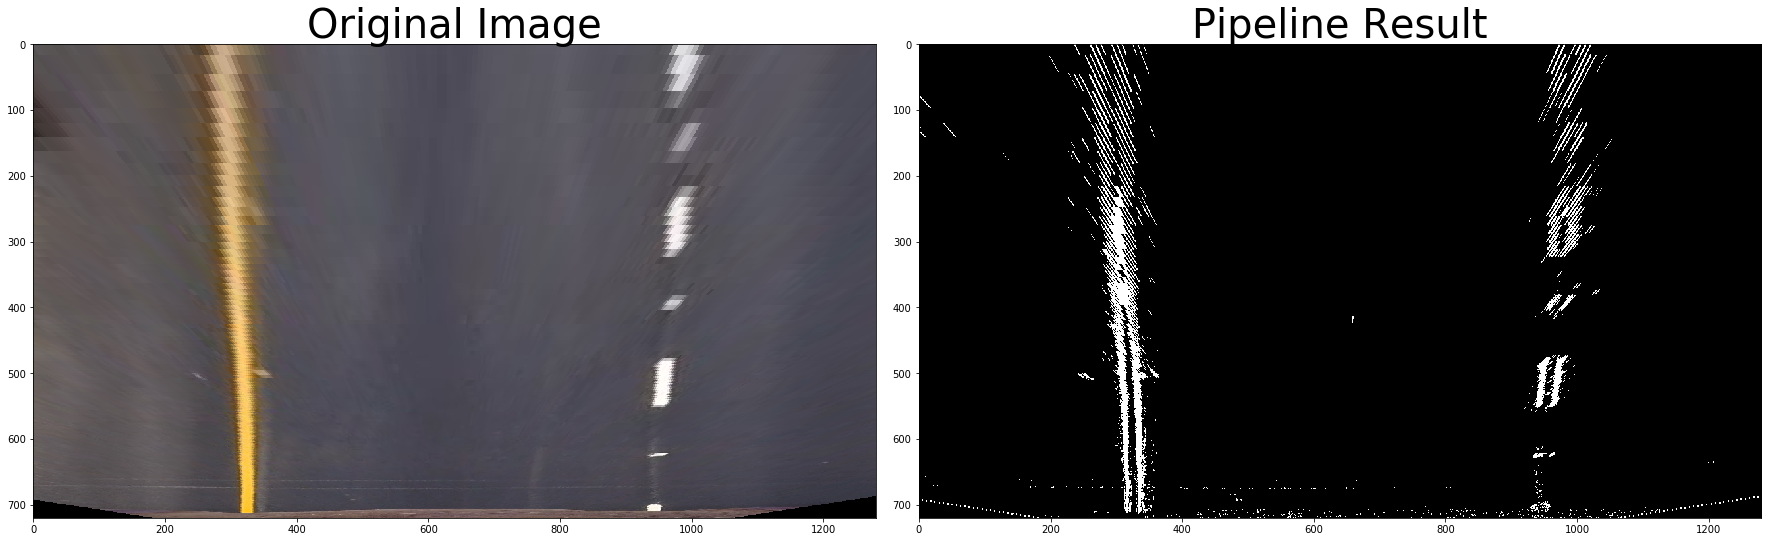

In [120]:

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1] # or h_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    # return color_binary
    
result = pipeline(warped, s_thresh=(140, 200), sx_thresh=(10, 140))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
write_name = 'output_images/pipeline_result.jpg'
cv2.imwrite(write_name, result)

## Use Histrogram to find the lanes in the above image

left_fit and right_fit [  7.24561566e-06   6.52863822e-02   2.83205182e+02] [ -7.95818140e-05  -1.67929416e-02   9.90843419e+02]


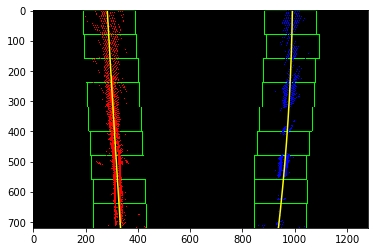

In [75]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2)

        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit


out_img, left_fit, right_fit = fit_polynomial(result)
print ("left_fit and right_fit",left_fit, right_fit)
plt.imshow(out_img,  aspect='auto')



### Measure Radius Of Curvature and use previously found co-ordinates to search around line line 

Measure Radius Of Curvature for both the lines More parellel line is more the radius will be.
Use previous found co-ordintes to look around the poly to find any change in lane cofficients

In [79]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    if left_fit_cr[0] == 0 or right_fit_cr[0] == 0:
        return 0, 0
    ##### calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

In [80]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    left_fitx = (left_fit[0]*ploty**2) + (left_fit[1]*ploty) + left_fit[2]
    right_fitx = (right_fit[0]*ploty**2) + (right_fit[1]*ploty) + right_fit[2]

    return left_fitx, right_fitx, ploty

Measure Radius Of Curvature =  69454.8135949 6287.22418098


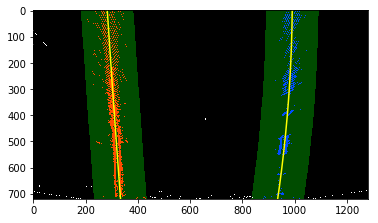

In [82]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])


    left_lane_neg_margin = ((left_fit[0]*nonzeroy**2) + (left_fit[1]*nonzeroy) + left_fit[2] - margin)
    left_lane_pos_margin = ((left_fit[0]*nonzeroy**2) + (left_fit[1]*nonzeroy) + left_fit[2] + margin)
    right_lane_neg_margin = ((right_fit[0]*nonzeroy**2) + (right_fit[1]*nonzeroy) + right_fit[2] - margin)
    right_lane_pos_margin = ((right_fit[0]*nonzeroy**2) + (right_fit[1]*nonzeroy) + right_fit[2] + margin)
    left_lane_inds = ((nonzerox >= left_lane_neg_margin) & (nonzerox <= left_lane_pos_margin))
    right_lane_inds = ((nonzerox >= right_lane_neg_margin) & (nonzerox <= right_lane_pos_margin))


    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +  right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit, right_fit)
    print ("Measure Radius Of Curvature = ", left_curverad, right_curverad)
    
   
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
lane_poly = search_around_poly(result)

# View your output
plt.imshow(lane_poly)

# Combine all the function from above processing

In [122]:
def find_lane_pixels(binary_warped, nwindows = 9, margin = 100, minpix = 50):
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    # Set the width of the windows +/- margin
    # Set minimum number of pixels found to recenter window


    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height

        ###  Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###\
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img



def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape-1, img_shape)
    ### Calc both polynomials using ploty, left_fit and right_fit ###

    left_fitx = (left_fit[0]*ploty**2) + (left_fit[1]*ploty) + left_fit[2]
    right_fitx = (right_fit[0]*ploty**2) + (right_fit[1]*ploty) + right_fit[2]

    return left_fit, right_fit, left_fitx, right_fitx, ploty

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)


def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1] # or h_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) 
    # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary



def measure_curvature_real_center(lane_values, left_fit, right_fit, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    if lane_values <=0:
        lane_values = 600
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/lane_values #700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix

    ##### Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit[0]*y_eval + left_fit[1])**2)**1.5)/np.absolute(2*left_fit[0])
    right_curverad = ((1+(2*right_fit[0]*y_eval + right_fit[1])**2)**1.5)/np.absolute(2*right_fit[0])
    avg_curv = (left_curverad+ right_curverad)/2
    # Let camera is at the center of the car
    center_of_image = 640 
    distance_from_center = (center_of_image - lane_values)*xm_per_pix
    return distance_from_center, left_curverad, right_curverad


def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_neg_margin = ((left_fit[0]*nonzeroy**2) + (left_fit[1]*nonzeroy) + left_fit[2] - margin)
    left_lane_pos_margin = ((left_fit[0]*nonzeroy**2) + (left_fit[1]*nonzeroy) + left_fit[2] + margin)
    right_lane_neg_margin = ((right_fit[0]*nonzeroy**2) + (right_fit[1]*nonzeroy) + right_fit[2] - margin)
    right_lane_pos_margin = ((right_fit[0]*nonzeroy**2) + (right_fit[1]*nonzeroy) + right_fit[2] + margin)
    left_lane_inds = ((nonzerox >= left_lane_neg_margin) & (nonzerox <= left_lane_pos_margin))
    right_lane_inds = ((nonzerox >= right_lane_neg_margin) & (nonzerox <= right_lane_pos_margin))


    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +  right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

## Run for complete for single image

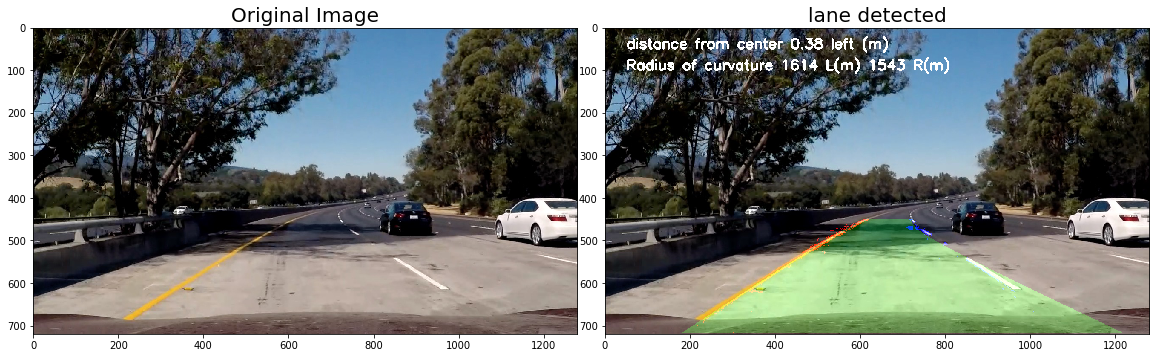

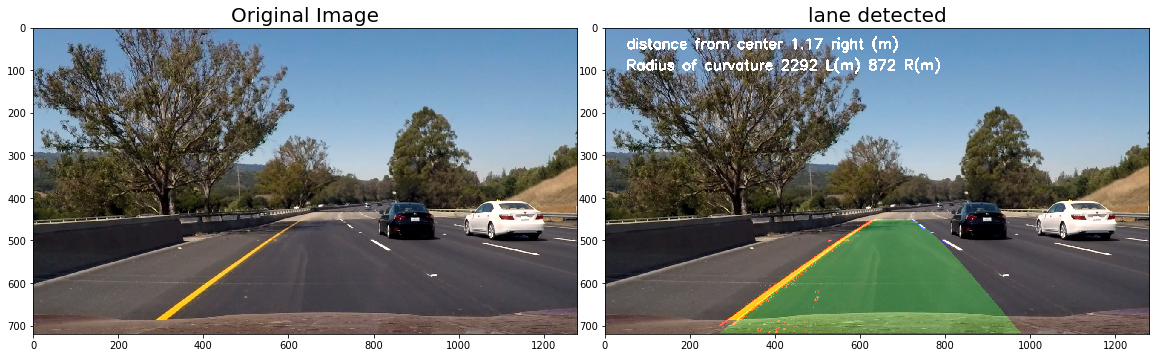

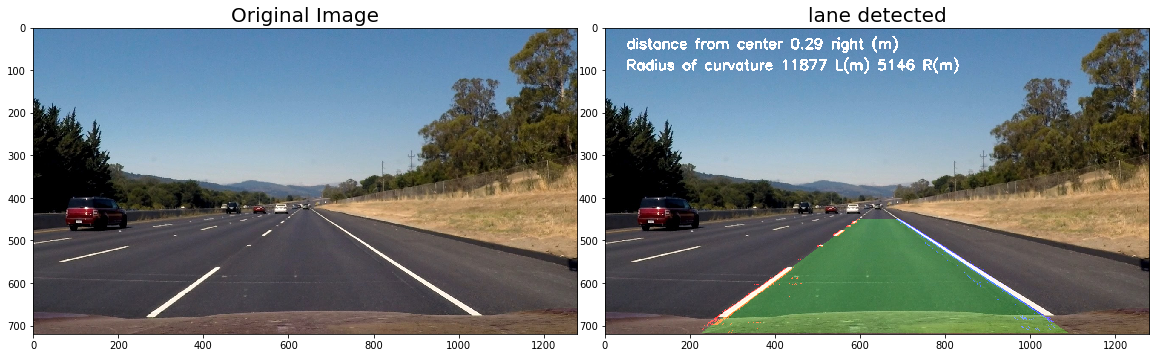

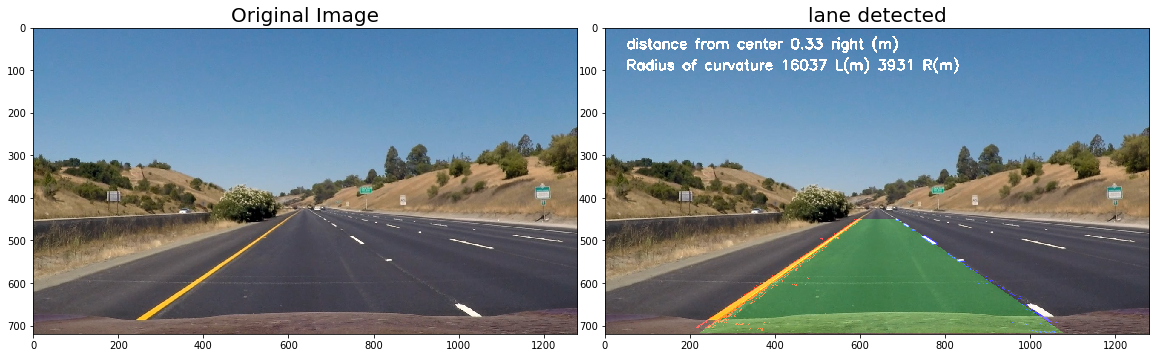

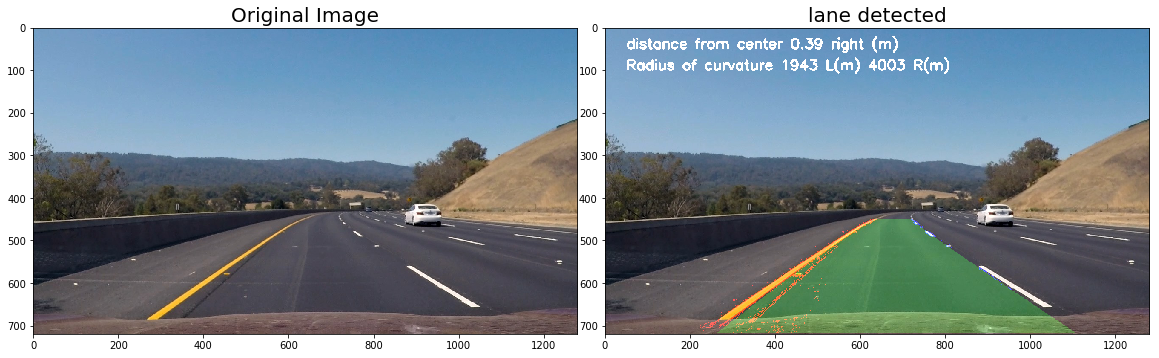

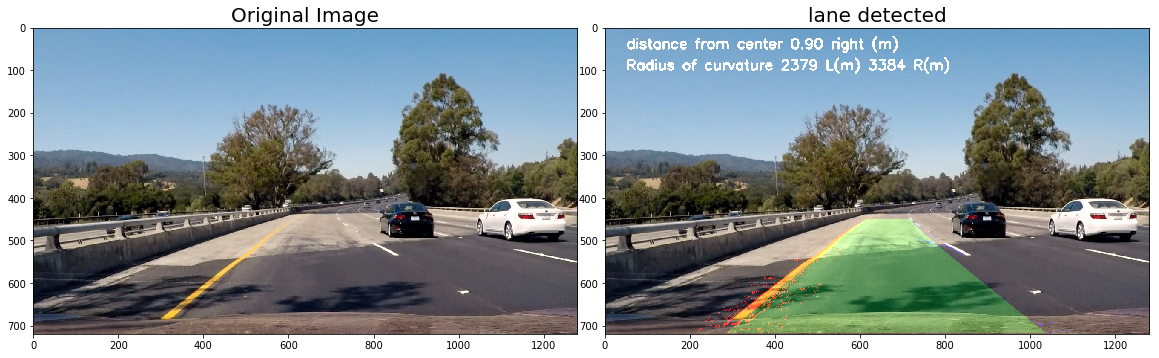

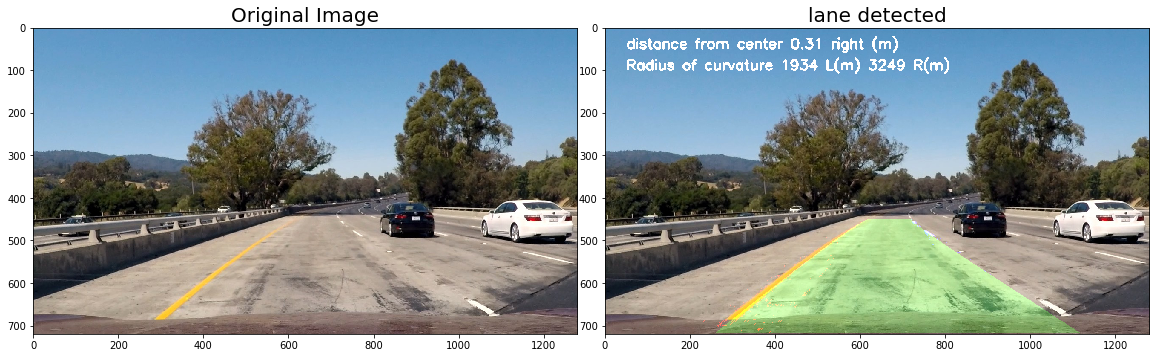

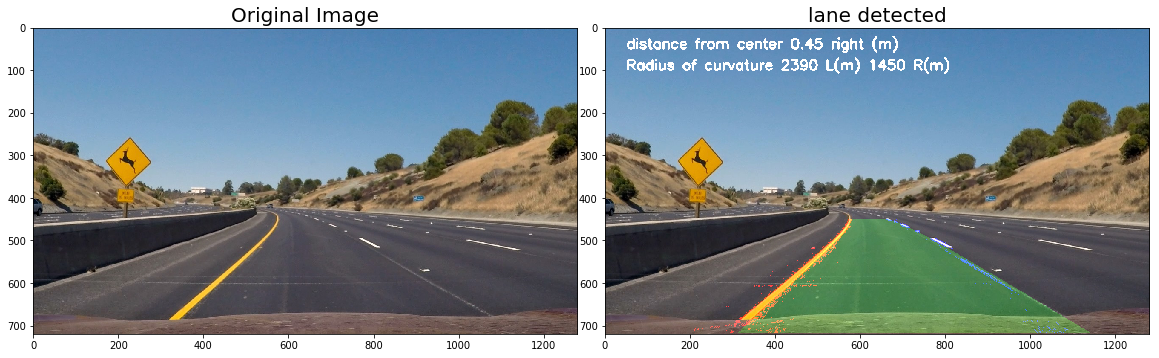

In [105]:
def main_one_image(image):
    undist, _, _ = cal_undistort(image, objpoints, imgpoints)
    # for region of interest
    img_pipeline = pipeline(undist, s_thresh=(140, 200), sx_thresh=(10, 140))
    # warp to bird eye view
    vertices = np.array([[(190,720),(610, 410),(670, 410), (1100,720)]],dtype=np.int32)
    img_roi = region_of_interest(img_pipeline, vertices)
    src_for_warp = np.array([[(196,720),(600, 450),(680, 450), (1135,720)]],dtype=np.float32)
    dst_for_warp = np.array([[(320,720),(320, 0),(960, 0),(960,720)]], dtype=np.float32)
    warped = warper(img_roi, src_for_warp, dst_for_warp)
    # Apply thresh hold and gradient
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    # get line coefficients and line pixels
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(warped.shape[0], leftx, lefty, rightx, righty)
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img_min = np.dstack((warped, warped, warped))*255
    out_img = np.zeros_like(out_img_min)
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((right_line, left_line ))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    # calculate curvature for the lines
    # Calculate the radius of curvature in meters for both lane lines
    distance_from_center, left_curv, right_curv  = measure_curvature_real_center(int(right_fitx[719]-left_fitx[719]), left_fit, right_fit, ploty)

    # un-warp the image
    dst_unwarp = np.array([[(196,720),(600, 450),(680, 450), (1135,720)]],dtype=np.float32)
    src_unwarp = np.array([[(320,720),(320, 0),(960, 0),(960,720)]], dtype=np.float32)
    unwarped = warper(result, src_unwarp, dst_unwarp)
    # add the calculated lines on the color image
    img2 = weighted_img(image, unwarped)
    side = ""
    if distance_from_center > 0:
        side = "right"
    else:
        side = "left"
    distance_text = "distance from center "+ str("{:.2f}".format(abs(distance_from_center)))+ " " + side +" (m)"
    
    curvature_text = "Radius of curvature " + str(int(left_curv)) + " L(m) " + str(int(right_curv))+ " R(m) "
    
    cv2.putText(img2, distance_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255,255,255), 4)
    cv2.putText(img2, curvature_text, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255,255,255), 4)
    return img2

######################################### Test function #########################
# Read Image
images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_result = main_one_image(image)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05) #found in documentaion
    ax1.imshow(image)
    ax1.set_title("Original Image", fontsize=20)
    ax2.imshow(image_result)
    ax2.set_title("lane detected", fontsize=20)
    write_name = 'output_images/lane_detected_examples_output_'+str(idx)+'.jpg'
    cv2.imwrite(write_name, image_result)

plt.show()


# Use Line class to store previous values (To use in video)

Also add function search_around_poly() this time 

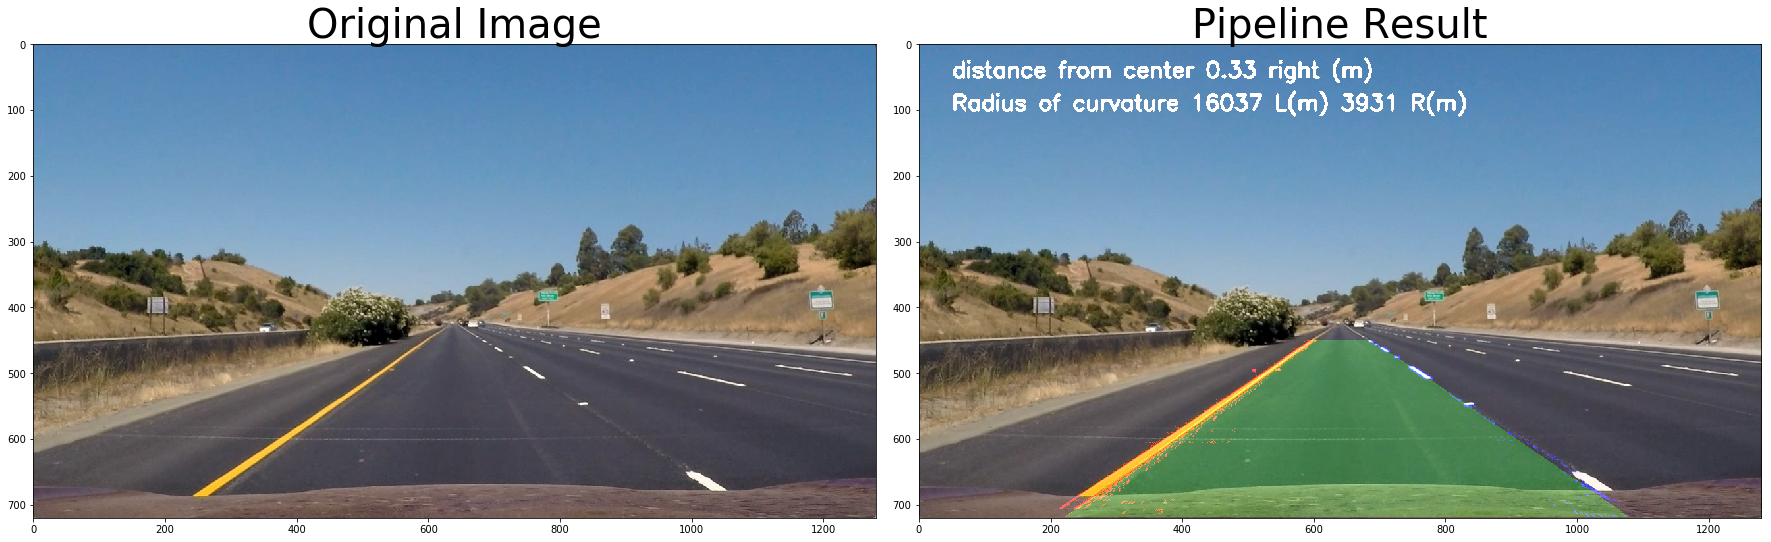

In [111]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        #radius of curvature of the line in some units
        self.radius_of_curvature_right = None
        self.radius_of_curvature_left = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #number of iteration
        self.n = 0
        #reset after n iteration
        self.src_for_warp = np.array([[(196,720),(600, 450),(680, 450), (1135,720)]],dtype=np.float32)
        self.dst_for_warp = np.array([[(320,720),(320, 0),(960, 0),(960,720)]], dtype=np.float32)
        # avg left fit and avg right fit
        self.left_fit_avg = np.array([0,0,0])
        self.right_fit_avg = np.array([0,0,0])
        # x fits and y fits
        self.left_fitx = np.array([0,0,0])
        self.right_fitx = np.array([0,0,0])

    def calculate_line_avg(self):
        self.left_fit_avg = ((self.left_fit_avg*self.n) + self.left_fit)/(self.n+1)
        self.right_fit_avg = ((self.right_fit_avg*self.n) + self.right_fit)/(self.n+1)
        # reset the average after every x frames
        if self.n == 20:
            self.detected = False
            self.n = 0

    def is_data_correct(self, distance_between_pix):
        #currently out distance between two  lines are arount 600 px
        #so we will remove the lines giving us wrong data
        if distance_between_pix >750 or distance_between_pix <= 450:
            self.detected = False
            return False
        return True

line_save = Line()

def one_image_processing(image):

    undist, _, _ = cal_undistort(image, objpoints, imgpoints)
    # Apply thresh hold and gradient for region of interest
    img_pipeline = pipeline(undist, s_thresh=(140, 200), sx_thresh=(10, 140))
    vertices = np.array([[(190,720),(610, 410),(670, 410), (1100,720)]],dtype=np.int32)
    img_roi = region_of_interest(img_pipeline, vertices)
    # warp to bird eye view
    warped = warper(img_roi, line_save.src_for_warp, line_save.dst_for_warp)
    # fit lane line on image
    if line_save.detected:
        leftx, lefty, rightx, righty = search_around_poly(warped, line_save.left_fit, line_save.right_fit)
    else:
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
        line_save.detected = True
        # get line coefficients and line pixels

    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(warped.shape[0], leftx, lefty, rightx, righty)

    px_distace_at_base = int(right_fitx[719]-left_fitx[719])

    # fill Line class with variables
    is_data_correct = line_save.is_data_correct(px_distace_at_base)
    if not is_data_correct:
        left_fitx = line_save.left_fitx
        right_fitx = line_save.right_fitx
        left_fit = line_save.left_fit_avg
        right_fit = line_save.right_fit_avg
    # save data in line
    line_save.left_fitx = left_fitx
    line_save.right_fitx = right_fitx
    line_save.left_fit = left_fit
    line_save.right_fit = right_fit
    line_save.calculate_line_avg()
    line_save.n += 1

    # Colors in the left and right lane regions
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img_min = np.dstack((warped, warped, warped))*255
    out_img = np.zeros_like(out_img_min)
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((right_line, left_line ))


    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))

    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    distance_from_center, left_curv, right_curv  = measure_curvature_real_center(px_distace_at_base, left_fit, right_fit, ploty)
    # un-warp the image
    unwarped = warper(result, line_save.dst_for_warp, line_save.src_for_warp)

    img2 = weighted_img(image, unwarped)
    side = ""
    if distance_from_center > 0:
        side = "right"
    else:
        side = "left"
    distance_text = "distance from center "+ str("{:.2f}".format(abs(distance_from_center)))+ " " + side +" (m)"
    curvature_text = "Radius of curvature " + str(int(left_curv)) + " L(m) " + str(int(right_curv))+ " R(m) "

    cv2.putText(img2, distance_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255,255,255), 4)
    cv2.putText(img2, curvature_text, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255,255,255), 4)
    return img2


######################################### Test function #########################
# Read Image

image = mpimg.imread('test_images/straight_lines1.jpg')
image_result = one_image_processing(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(image_result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Test on video 

In [112]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = one_image_processing(image)
    return result

# Run project Video

In [113]:
white_output = 'test_videos_output/clip.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
line_save.detected = False
#clip1 = VideoFileClip("project_video.mp4").subclip(21,25)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/clip.mp4
[MoviePy] Writing video test_videos_output/clip.mp4


100%|█████████▉| 1260/1261 [32:19<00:01,  1.67s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/clip.mp4 

CPU times: user 29min 55s, sys: 12.1 s, total: 30min 7s
Wall time: 32min 22s


In [114]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# challenge video

In [123]:
# challenge_video.mp4
chal_white_output = 'test_videos_output/challenge_project_video.mp4'
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,6)
clip1 = VideoFileClip("challenge_video.mp4")
line_save.detected = False
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = one_image_processing(image)
    #result = main_one_image(image)
    return result
white_clip = clip1.fl_image(process_image) #function expects color images!!
%time white_clip.write_videofile(chal_white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_project_video.mp4
[MoviePy] Writing video test_videos_output/challenge_project_video.mp4



100%|██████████| 485/485 [12:13<00:00,  1.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_project_video.mp4 

CPU times: user 11min 25s, sys: 1.19 s, total: 11min 26s
Wall time: 12min 16s


In [125]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chal_white_output))